### Imports

In [1]:
from IPython.core.debugger import set_trace

#%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")

In [2]:
SENTIMENT_LABELLED_DATA_FILEPATH = '..\Data\Sentiment Analysis Dataset.csv'
DATA_PREPROCESSING_FILEPATH = '../Data Preprocessed'

#TOKENIZER_OUTPUT_FILEPATH = 'tokenizer_100K.pickle'
TOKENIZER_OUTPUT_FILEPATH = 'tokenizer_1M.pickle'

MODEL_OUTPUT_FILEPATH = 'model_1M_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove_91_X'

#### Dataset Import

In [2]:
txt_data = pd.read_csv(SENTIMENT_LABELLED_DATA_FILEPATH , sep='|', names=['col1'])

#split data into columns with ','
txt_data = txt_data.col1.str.split(',',  3, expand=True)
txt_data.columns = list(txt_data.iloc[0])
txt_data = txt_data.drop(0)
txt_data.index = np.subtract(txt_data.index, 1)


NameError: name 'pd' is not defined

In [5]:
dataset = pd.concat([txt_data['SentimentText'], txt_data['Sentiment']], axis = 1)
dataset.columns = ['text', 'target']

In [1]:
#suffle
dataset = dataset.sample(frac = 1)
dataset

NameError: name 'dataset' is not defined

#### NLP Imports

In [167]:
dataset.describe()

,text,target
count,1577838,1577838
unique,1577727,2
top,,1
freq,26,789771


In [56]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(DATA_PREPROCESSING_FILEPATH)
from data_preprocess import *

import pickle

In [57]:
text = NLP_preprocess(dataset)
text.preprocess_data()

text.set_tokenizer()
import pickle

# saving
with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
    pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Preprocessing

#### Train / Test Split - Tokenization - Padding

In [182]:
train_dataset = dataset[:1000000]
train_labels = train_dataset.target.astype(float)
train_padded = text.tokenize_and_pad(train_dataset, train = True)
print(train_padded)
# saving
with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
    pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

[[173741    285    478 ...      0      0      0]
 [ 75141     98      5 ...      0      0      0]
 [   841    191     15 ...      0      0      0]
 ...
 [   426    731     11 ...      0      0      0]
 [   206  36391   1199 ...      0      0      0]
 [   251     31   1113 ...      0      0      0]]


In [183]:
text.set_embedding_matrix()

In [184]:
pd.DataFrame(text.embedding_matrix).info


<bound method DataFrame.info of               0         1         2         3        4        5        6   \
0       0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   
1       0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   
2      -0.673910  0.544500 -0.448680  0.167630 -0.22777  0.56469  0.23045   
3       0.091552  0.093336 -0.028113  0.369900  0.18956  0.43191  0.10266   
4      -0.159680 -0.369660  0.237610 -0.124320  0.67826  0.11184  0.30487   
...          ...       ...       ...       ...      ...      ...      ...   
571419  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   
571420  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   
571421  0.355290  0.057615  0.474540 -0.015346  0.23300 -0.12013 -0.15524   
571422  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   
571423  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000   

              7         8         9   ...  

In [185]:
# Test dataset preporcess
test_dataset = dataset[:200000]
test_labels = test_dataset.target.astype(float)
test_padded = text.tokenize_and_pad(test_dataset, train = False)
print(test_padded)

[[173741    285    478 ...      0      0      0]
 [ 75141     98      5 ...      0      0      0]
 [   841    191     15 ...      0      0      0]
 ...
 [  2913   7099      0 ...      0      0      0]
 [    98     21    676 ...      0      0      0]
 [  4505 253219   2952 ...      0      0      0]]


### Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

model = Sequential()

# trainable = False
#bidirectional

#Glove
model.add(
    Embedding(
        text.num_words,
        100,
        embeddings_initializer = Constant(text.embedding_matrix),
        input_length = text.max_length,
        trainable = False,
    )
)

#basic
# for i in range(0,200):
# #model.add(Embedding(text.num_words, 8, input_length=text.max_length))
#     model.add(Dense(1000, activation='relu'))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

NameError: name 'text' is not defined

In [ ]:
model.summary()

In [188]:
history = model.fit(
    train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels),
)

Epoch 1/10
31250/31250 [==============================] - 150s 5ms/step - loss: 0.4896 - accuracy: 0.7627 - val_loss: 0.4573 - val_accuracy: 0.7827
Epoch 2/10
31250/31250 [==============================] - 140s 4ms/step - loss: 0.4608 - accuracy: 0.7807 - val_loss: 0.4462 - val_accuracy: 0.7902
Epoch 3/10
31250/31250 [==============================] - 147s 5ms/step - loss: 0.4488 - accuracy: 0.7879 - val_loss: 0.4357 - val_accuracy: 0.7925
Epoch 4/10
31250/31250 [==============================] - 171s 5ms/step - loss: 0.4416 - accuracy: 0.7921 - val_loss: 0.4273 - val_accuracy: 0.8012
Epoch 5/10
31250/31250 [==============================] - 203s 6ms/step - loss: 0.4392 - accuracy: 0.7930 - val_loss: 0.4404 - val_accuracy: 0.7864
Epoch 6/10
31250/31250 [==============================] - 209s 7ms/step - loss: 0.4519 - accuracy: 0.7848 - val_loss: 0.4489 - val_accuracy: 0.7847
Epoch 7/10
31250/31250 [==============================] - 211s 7ms/step - loss: 0.4575 - accuracy: 0.7829 - val_

In [199]:
model.save(MODEL_OUTPUT_FILEPATH)

MemoryError: 

In [198]:
model = keras.models.load_model(MODEL_OUTPUT_FILEPATH)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           57142400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 57,222,901
Trainable params: 80,501
Non-trainable params: 57,142,400
_________________________________________________________________


#### Sample evaluation

In [190]:
import random
#test_neg = random.choice(neg.values)
i = random.choice(test_dataset.index)
if test_dataset.loc[i]['target'] == '0':
    print('negative: ', test_dataset.loc[i]['text'])
else:
    print('positive: ', test_dataset.loc[i]['text'])
test_sequences = text.tokenizer.texts_to_sequences([test_dataset.loc[i]['text']])
test_padded2 = pad_sequences(
    test_sequences, maxlen=text.max_length, padding="post", truncating="post"
)
model.predict(test_padded2)

positive:  ok pimp want


array([[0.52478486]], dtype=float32)

### Analytics

#### ROC graphs

In [191]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_padded).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)

In [192]:
#inverse the labels to get the negative rates
inversed_y_pred_keras = pd.DataFrame(y_pred_keras).apply(lambda x: abs(x-1))
#false positivee is true negative here and true positive is false negative
tnr_keras, fnr_keras, thresholds_keras2 = roc_curve(test_labels, inversed_y_pred_keras)

In [32]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fnr_keras, tnr_keras)

NameError: name 'fpr_keras' is not defined

In [33]:
model

NameError: name 'model' is not defined

In [194]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(train_padded, train_labels)

y_pred_rf = rf.predict_proba(test_padded)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_labels, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

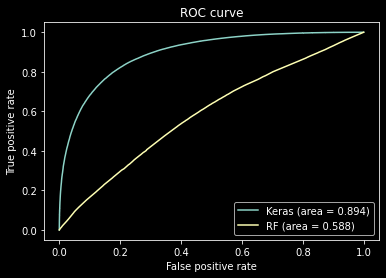

In [195]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [113]:
test_labels

969154     0.0
1440799    1.0
1277006    0.0
779736     1.0
627404     0.0
          ... 
1039860    1.0
58323      1.0
1061774    1.0
682557     1.0
1004894    1.0
Name: target, Length: 20000, dtype: float64

#### Confusion Matrix

In [156]:
df = pd.DataFrame(y_pred_keras, columns = ["predicted"])
#make predictions either 0 or 1
df["predicted"] = df["predicted"].apply(lambda x: round(x))
test_labels.index = df.index
df = pd.concat([df,test_labels], axis =1)
df

,predicted,target
0,0,0.0
1,1,1.0
2,0,0.0
3,1,1.0
4,1,0.0
...,...,...
19995,1,1.0
19996,1,1.0
19997,1,1.0
19998,1,1.0


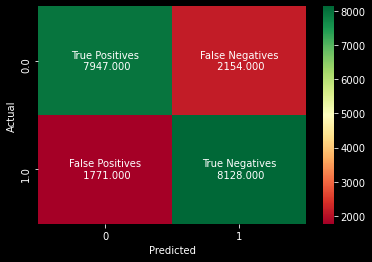

In [160]:
import seaborn as sn
confusion_matrix = pd.crosstab(df['target'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
strings = strings = np.asarray([['True Positives\n', 'False Negatives\n'],
                                ['False Positives\n', 'True Negatives\n']])
labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               confusion_matrix.values.flatten())])
         ).reshape(2, 2)

fig, ax = plt.subplots()
sn.heatmap(confusion_matrix, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
plt.show()


In [165]:
tp = confusion_matrix[0][0]
fn = confusion_matrix[1][0]

tn = confusion_matrix[1][1]
fp = confusion_matrix[0][1]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)

Sensitivity:  0.7867537867537867
Specificity:  0.8210930397009799
